In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aging.behavior.syllables import relabel_by_usage
from sklearn.cross_decomposition import PLSRegression

In [1]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [4]:
def load_df():
    df = pd.read_parquet('/Users/wingillis/db-hms/lab-datta/projects/ontogeny/data/parquet/ontogeny_males_syllable_df.parquet')
    df = relabel_by_usage(df, return_map=False)
    df['age'] = df['age'].map(age_map)

    usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
    usage_df.name = 'usage'
    usage_df = usage_df.reset_index()

    usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)
    return usage_mtx

In [5]:
usage_mtx = load_df()

In [93]:
um = usage_mtx.iloc[:, :]

In [94]:
mdl = PLSRegression(n_components=2)
mdl.fit(um, um.index.get_level_values('age'))

PLSRegression()

In [95]:
mdl.x_loadings_.shape

(63, 2)

In [96]:
projection = mdl.transform(um)

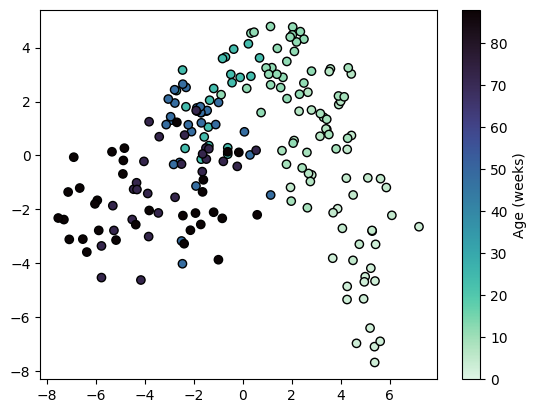

In [97]:
plt.scatter(projection[:, 0], projection[:, 1], c=um.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

## Longtogeny

In [98]:
df = pd.read_parquet('/Users/wingillis/db-hms/lab-datta/projects/ontogeny/data/parquet/longtogeny_males_syllable_df.parquet')
df = relabel_by_usage(df, return_map=False)

In [99]:
df.head()

,experiment,file,syllables,date,uuid,age,session_name,subject_name,timestamps,area_mm,...,velocity_2d_mm,velocity_3d_mm,width_mm,angle,velocity_theta,recon_width,recon_length,recon_height,onsets,relabeled_syllables
0,longtogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/longtog...,81,2021-07-30 14:13:02,002b6a34-3a71-4269-8e50-85b493e0245f,None,080,01_04_080,0.000000,3267.034424,...,0.0,0.0,61.260475,3.373493,0.0,29.320924,60.537044,31.407869,True,39
1,longtogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/longtog...,81,2021-07-30 14:13:02,002b6a34-3a71-4269-8e50-85b493e0245f,None,080,01_04_080,0.033333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,39
2,longtogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/longtog...,81,2021-07-30 14:13:02,002b6a34-3a71-4269-8e50-85b493e0245f,None,080,01_04_080,0.066667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,39
3,longtogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/longtog...,81,2021-07-30 14:13:02,002b6a34-3a71-4269-8e50-85b493e0245f,None,080,01_04_080,0.100000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,39
4,longtogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/longtog...,81,2021-07-30 14:13:02,002b6a34-3a71-4269-8e50-85b493e0245f,None,080,01_04_080,0.133333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,39


In [101]:
df['mouse_id'] = df['subject_name'].str[:5]
earliest_mouse_age = 24  # weeks

In [110]:
def age(df):
    return ((df['date'] - df['date'].min()).dt.days + earliest_mouse_age) / 7
ages = df.groupby('mouse_id', sort=False).apply(age)
df['age'] = ages.values

<Axes: >

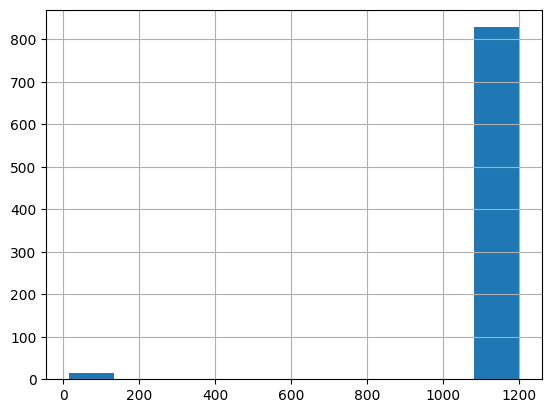

In [118]:
# clean up the data by removing short sessions
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < 600].index
session_length.hist()

In [121]:
df = df[~df['uuid'].isin(remove_uuids)]

In [122]:
usage_df = df.query('onsets').groupby(['age', 'mouse_id', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'mouse_id', 'uuid']).fillna(0)

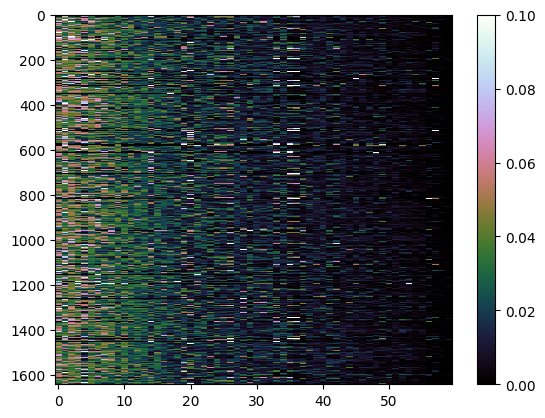

In [126]:
plt.imshow(usage_mtx, aspect='auto', interpolation='none', cmap='cubehelix', vmin=0, vmax=0.1)
plt.colorbar()

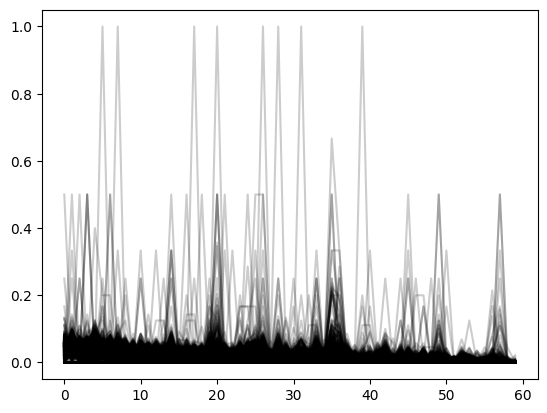

In [134]:
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

In [129]:
# remove sessions with abnormally high syllable usage
usage_mtx = usage_mtx[~(usage_mtx > 0.2).any(axis=1)]

In [135]:
mdl = PLSRegression(n_components=2)
mdl.fit(usage_mtx, usage_mtx.index.get_level_values('age'))

PLSRegression()